# 使用AutoEncoder進行時間序列異常偵測

我們使用[Numenta Anomaly Benchmark(NAB)](https://www.kaggle.com/boltzmannbrain/nab) kaggle資料集為範例，來介紹AutoEncoder(AE)模型的應用.

訓練資料集: (artificialNoAnomaly) `art_daily_small_noise.csv` 計4032筆資料 - 每5分鐘收一次資料，一天288筆，共有14天

測試資料集: (artificialNoAnomaly) `art_daily_jumpsup.csv` 計4032筆資料 - 每5分鐘收一次資料，一天288筆，共有14天


程式內容包括:

* 載入資料集 (CSV file).
* 建立訓練集及測試集..等資料.
* 訓練AE模型 (使用`keras.layers.Conv1D`建立模型架構).
* 評估模型績效 (precision and recall).


### AutoEncoder模型架構

![AE](pic_AE/AE.png)

## 載入工具

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

## 載入資料集

資料集: [Numenta Anomaly Benchmark(NAB)](
https://www.kaggle.com/boltzmannbrain/nab) dataset. 資料依timestamp排序, 記錄每一timestamp的 single value.

training set file: `art_daily_small_noise.csv`

testing set file: `art_daily_jumpsup.csv`

In [4]:
df_small_noise = pd.read_csv('datasets/timeseries_data/art_daily_small_noise.csv', 
                             parse_dates=True, index_col="timestamp")

df_daily_jumpsup = pd.read_csv('datasets/timeseries_data/art_daily_jumpsup.csv', 
                            parse_dates=True, index_col="timestamp")

## 資料處理及資料探索(EDA)

In [5]:
print(df_small_noise.head(3))
print(df_daily_jumpsup.head(3))

                         value
timestamp                     
2014-04-01 00:00:00  18.324919
2014-04-01 00:05:00  21.970327
2014-04-01 00:10:00  18.624806
                         value
timestamp                     
2014-04-01 00:00:00  19.761252
2014-04-01 00:05:00  20.500833
2014-04-01 00:10:00  19.961641


In [6]:
print("---- art_daily_small_noise.csv ----")
print(df_small_noise.describe())
print()
print("---- art_daily_jumpsup.csv ----")
print(df_daily_jumpsup.describe())

---- art_daily_small_noise.csv ----
             value
count  4032.000000
mean     42.438353
std      28.077122
min      18.000964
25%      19.841390
50%      21.608487
75%      75.450282
max      87.976128

---- art_daily_jumpsup.csv ----
             value
count  4032.000000
mean     44.494254
std      32.432473
min      18.001010
25%      19.991382
50%      21.648503
75%      76.435943
max     164.947481


## 資料視覺化
### 沒有異常的時間序列資料

使用 trainings set資料來顯示. (art_daily_small_noise.csv)

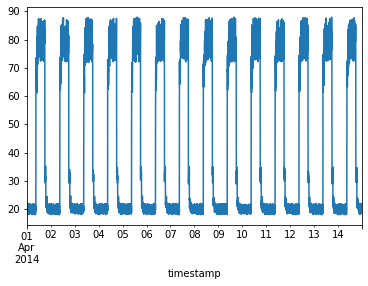

In [7]:
fig, ax = plt.subplots()
df_small_noise.plot(legend=False, ax=ax)
plt.show()

### 有異常的時間序列資料

使用 test set資料來顯示. (art_daily_jumpsup.csv)

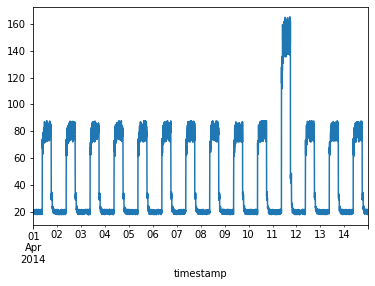

In [8]:
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
plt.show()

## 準備訓練集

timestep為每五分鐘記錄一筆，一天有288筆, 總共收集了14天, 合計4032筆資料。

-   24 * 60 / 5 = **288 timesteps per day**
-   288 * 14 = **4032 data points** in total

#### 資料標準化處理

In [9]:
# Normalize and save the mean and std we get,
# for normalizing test data.
training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
df_training_value = (df_small_noise - training_mean) / training_std
print("Number of training samples:", len(df_training_value))

Number of training samples: 4032


### 建立每天一筆，每筆288個欄位之序列資料，為訓練集

In [10]:
TIME_STEPS = 288

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

Training input shape:  (3744, 288, 1)


## 建立模型

使用1D CNN來建立Autoencoder模型, input of shape `(batch_size, sequence_length, num_features)` output一樣的shape(batch_size, 288, 1)

In [11]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 144, 32)           256       
_________________________________________________________________
dropout (Dropout)            (None, 144, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 72, 16)            3600      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 144, 16)           1808      
_________________________________________________________________
dropout_1 (Dropout)          (None, 144, 16)           0         
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 288, 32)           3616      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 288, 1)            2

## 訓練模型
使用`x_train`資料為input data(X), 同時也為output data(Y)

In [12]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
27/27 [==============================] - 6s 26ms/step - loss: 0.7178 - val_loss: 0.0619
Epoch 2/50
27/27 [==============================] - 0s 13ms/step - loss: 0.0845 - val_loss: 0.0471
Epoch 3/50
27/27 [==============================] - 0s 11ms/step - loss: 0.0578 - val_loss: 0.0354
Epoch 4/50
27/27 [==============================] - 0s 11ms/step - loss: 0.0497 - val_loss: 0.0324
Epoch 5/50
27/27 [==============================] - 0s 11ms/step - loss: 0.0449 - val_loss: 0.0292
Epoch 6/50
27/27 [==============================] - 0s 11ms/step - loss: 0.0408 - val_loss: 0.0270
Epoch 7/50
27/27 [==============================] - 0s 11ms/step - loss: 0.0374 - val_loss: 0.0246
Epoch 8/50
27/27 [==============================] - 0s 11ms/step - loss: 0.0341 - val_loss: 0.0225
Epoch 9/50
27/27 [==============================] - 0s 11ms/step - loss: 0.0314 - val_loss: 0.0213
Epoch 10/50
27/27 [==============================] - 0s 11ms/step - loss: 0.0293 - val_loss: 0.0202
Epoch 11/

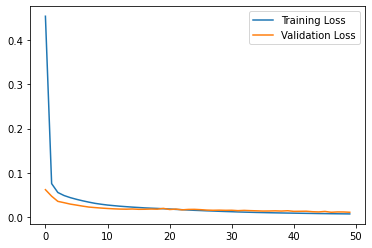

In [13]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

## 偵測異常

偵測異常的方式，是以MAE來衡量AE所output的sequence資料與input的差異.(需設定一個threshold來判斷OK/NG)

1.   計算所有training set資料的 MAE loss，在本異常偵測案例中亦稱為`anomaly score`.
2.   以最大 max MAE loss為一個上限門檻值(`threshold`)，超過這個門檻我們稱為異常(`anomaly`).

In [14]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

In [15]:
x_train_pred.shape

(3744, 288, 1)

Reconstruction error threshold:  0.09079678386843798


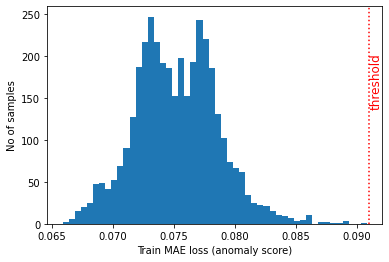

In [16]:
# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss (anomaly score)")
plt.ylabel("No of samples")

plt.axvline(round(threshold,3), color='red', linestyle='dotted')
plt.text(round(threshold,3), 140, 'threshold', rotation='vertical', color='red', fontsize=12)
plt.show()

### 比較input data跟AE output的線形

每一筆資料為1天, 有288個timesteps

train MAE Loss(anomaly score):0.0737, threshold:0.0908 


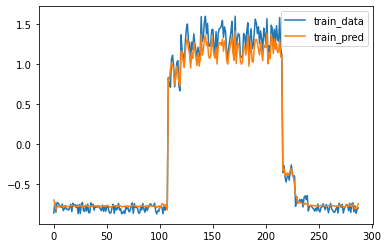

In [17]:
record_num = 0

# Get train MAE loss.
train_mae_loss = np.mean(np.abs(x_train_pred[record_num] - x_train[record_num]))
print("train MAE Loss(anomaly score):{}, threshold:{} ".format(round(train_mae_loss,4), round(threshold,4)))

# Checking how the first sequence is learnt
plt.plot(x_train[record_num], label='train_data')
plt.plot(x_train_pred[record_num], label='train_pred')
plt.legend(loc='best')
plt.show()

train MAE Loss(anomaly score):0.0755, threshold:0.0908 


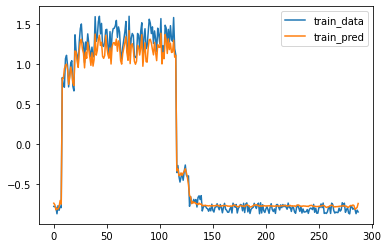

In [18]:
record_num = 100

# Get train MAE loss.
train_mae_loss = np.mean(np.abs(x_train_pred[record_num] - x_train[record_num]))
print("train MAE Loss(anomaly score):{}, threshold:{} ".format(round(train_mae_loss,4), round(threshold,4)))

# Checking how the first sequence is learnt
plt.plot(x_train[record_num], label='train_data')
plt.plot(x_train_pred[record_num], label='train_pred')
plt.legend(loc='best')
plt.show()

### 準備測試資料

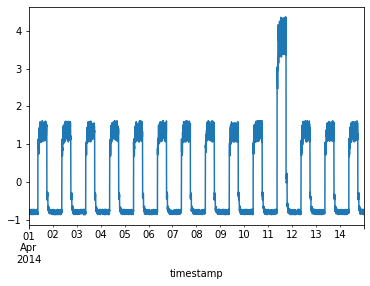

Test input shape:  (3744, 288, 1)


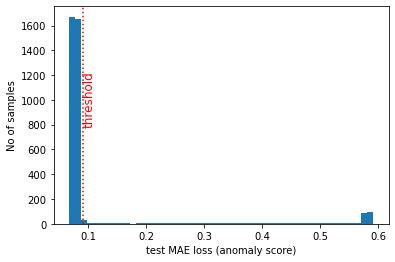

Number of anomaly samples:  401
Indices of anomaly samples(MAE > threshold):  (array([ 793,  794,  795,  797, 1945, 2521, 2701, 2702, 2703, 2704, 2705,
       2706, 2707, 2708, 2709, 2710, 2711, 2712, 2713, 2714, 2715, 2716,
       2717, 2718, 2719, 2720, 2721, 2722, 2723, 2724, 2725, 2726, 2727,
       2728, 2729, 2730, 2731, 2732, 2733, 2734, 2735, 2736, 2737, 2738,
       2739, 2740, 2741, 2742, 2743, 2744, 2745, 2746, 2747, 2748, 2749,
       2750, 2751, 2752, 2753, 2754, 2755, 2756, 2757, 2758, 2759, 2760,
       2761, 2762, 2763, 2764, 2765, 2766, 2767, 2768, 2769, 2770, 2771,
       2772, 2773, 2774, 2775, 2776, 2777, 2778, 2779, 2780, 2781, 2782,
       2783, 2784, 2785, 2786, 2787, 2788, 2789, 2790, 2791, 2792, 2793,
       2794, 2795, 2796, 2797, 2798, 2799, 2800, 2801, 2802, 2803, 2804,
       2805, 2806, 2807, 2808, 2809, 2810, 2811, 2812, 2813, 2814, 2815,
       2816, 2817, 2818, 2819, 2820, 2821, 2822, 2823, 2824, 2825, 2826,
       2827, 2828, 2829, 2830, 2831, 2832, 28

In [19]:

def normalize_test(values, mean, std):
    values -= mean
    values /= std
    return values


df_test_value = (df_daily_jumpsup - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.axvline(round(threshold,3), color='red', linestyle='dotted')
plt.text(round(threshold,3), 800, 'threshold', rotation='vertical', color='red', fontsize=12)

plt.xlabel("test MAE loss (anomaly score)")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples(MAE > threshold): ", np.where(anomalies))

## 繪製異常示例

假設:我們定義一個檢查異常值出現的filter windows為3個刻度。即前/中/後三個刻度(data_idx)都有包括這個異常值，才稱作此刻度有異常出現。
- 前: data_idx - 1
- 中: data_idx
- 後: data_idx + 1

例如: 數列刻度(或:欄位ID)為0~9, 由filter windows=3, 一次向右一刻度, 掃過後的組合如下:

- 0, 1, 2
- 1, 2, 3
- 2, 3, 4
- 3, 4, 5
- 4, 5, 6
- 5, 6, 7
- 6, 7, 8
- 7, 8, 9

假設有這三組(前/中/後)組合[(3, 4, 5), (4, 5, 6), (5, 6, 7)], 都有出現異常值, 我們稱它共同包括的第5刻度為異常(anomaly)。

目前測試集的資料，也是由5分鐘一單位，一天288個刻度組成。 (TIME_STEPS=288)

現在我們把filter windows放大到288-1, filter windows=287, 則是檢查一整天的長度來偵測那一天有異常值出現。

In [20]:
#我們要檢查的範圍
TIME_STEPS -1 , len(df_test_value) - TIME_STEPS + 1

(287, 3745)

註:`np.array.all()`是`and`操作，將`np.array`中所有元素進行`and`操作，然後返回`True`或`False`

In [21]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        #print("data_idx:{}, data_idx-TIME_STEPS+1:{}, Range:{}".format(data_idx, data_idx-TIME_STEPS+1, data_idx-data_idx - TIME_STEPS + 1))
        anomalous_data_indices.append(data_idx)

### 將異常data indices以紅線標示

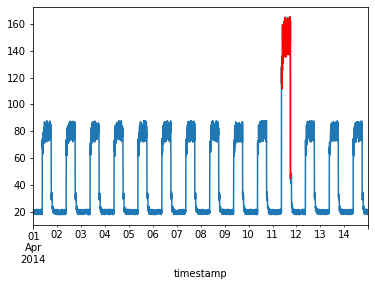

In [22]:
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()

----

另外參考: https://www.tensorflow.org/tutorials/generative/autoencoder (使用MLP)

In [23]:
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses

class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Dense(288, activation="relu"),
            layers.Dense(144, activation="relu"),
            layers.Dense(16, activation="relu")])

        self.decoder = tf.keras.Sequential([
            layers.Dense(16, activation="relu"),
            layers.Dense(144, activation="relu"),
            layers.Dense(288, activation='selu'),
            layers.Dense(1, activation='sigmoid')])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = AnomalyDetector()

In [24]:
autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")

In [25]:
history = autoencoder.fit(x_train, x_train,  
          epochs=50,
          batch_size=128,
          validation_split=0.1,
          callbacks=[
          keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
          ],
          shuffle=True)

Epoch 1/50
27/27 [==============================] - 2s 55ms/step - loss: 0.9233 - val_loss: 0.4237
Epoch 2/50
27/27 [==============================] - 1s 40ms/step - loss: 0.4180 - val_loss: 0.4237
Epoch 3/50
27/27 [==============================] - 1s 39ms/step - loss: 0.4180 - val_loss: 0.4237
Epoch 4/50
27/27 [==============================] - 1s 39ms/step - loss: 0.4180 - val_loss: 0.4237
Epoch 5/50
27/27 [==============================] - 1s 40ms/step - loss: 0.4180 - val_loss: 0.4237
Epoch 6/50
27/27 [==============================] - 1s 39ms/step - loss: 0.4181 - val_loss: 0.4237
Epoch 7/50
27/27 [==============================] - 1s 39ms/step - loss: 0.4180 - val_loss: 0.4236
Epoch 8/50
27/27 [==============================] - 1s 39ms/step - loss: 0.4180 - val_loss: 0.4235
Epoch 9/50
27/27 [==============================] - 1s 40ms/step - loss: 0.4178 - val_loss: 0.4227
Epoch 10/50
27/27 [==============================] - 1s 40ms/step - loss: 0.4170 - val_loss: 0.4227
Epoch 11/

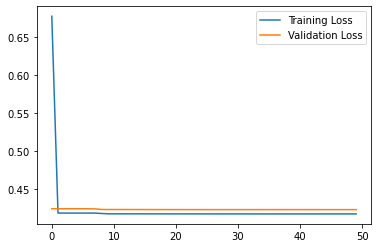

In [26]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

In [27]:
# Get train MAE loss.
x_train_pred = autoencoder.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

In [28]:
x_train_pred.shape

(3744, 288, 1)

Reconstruction error threshold:  0.5964664917686928


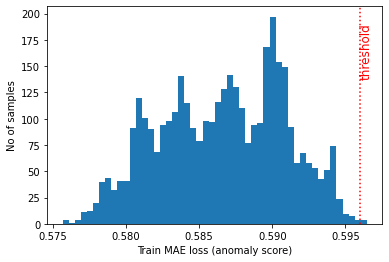

In [29]:
# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss (anomaly score)")
plt.ylabel("No of samples")

plt.axvline(round(threshold,3), color='red', linestyle='dotted')
plt.text(round(threshold,3), 140, 'threshold', rotation='vertical', color='red', fontsize=12)
plt.show()

train MAE Loss:0.5826, threshold:0.5965 


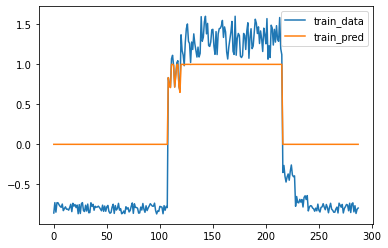

In [30]:
record_num = 0

# Get train MAE loss.
train_mae_loss = np.mean(np.abs(x_train_pred[record_num] - x_train[record_num]))
print("train MAE Loss:{}, threshold:{} ".format(round(train_mae_loss,4), round(threshold,4)))

# Checking how the first sequence is learnt
plt.plot(x_train[record_num], label='train_data')
plt.plot(x_train_pred[record_num], label='train_pred')
plt.legend(loc='best')
plt.show()

----